<a href="https://colab.research.google.com/github/jetafese/hwmcc20-mlir/blob/main/runbench/Btor2MLIR_experiment_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Btor2MLIR Experiment Results


## Setup & Utilities

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from matplotlib.backends.backend_pdf import PdfPages

# Do not limit number of rows displayed
pd.set_option('display.max_rows', None)
# constants
TO = 295.0
benchmark_categories = list(['wolf/18D', 'wolf/19A', 'wolf/19B', 'wolf/19C', 'beem', 'goel', '19/mann', '20/mann'])
array_categories = list(['wolf/18A', 'wolf/19A', 'wolf/19B', 'wolf/19C', '19/mann', '20/mann'])

In [ ]:
def clean_b2ir_csv(in_file, btor=False):
  df = pd.read_csv(in_file)
  df = df.rename(columns = {'index': 'base'})
  return df

def clean_btormc_csv(in_file, btor=False):
  df = pd.read_csv(in_file)
  df = df.rename(columns = {'index': 'base'})
  # handle special cases where trivially unsat
  df.loc[df['base'] == 'simple_alu.btor', 'status'] = 'unsat'
  df.loc[df['base'] == 'vcegar_QF_BV_itc99_b13_p10.btor2', 'status'] = 'unsat'
  # identify timeouts
  df['status'] = df['status'].fillna('unknown')
  df['status'] = df['status'].astype(str)
  df.loc[df['status'] == 'unknown', 'btor_time'] = 1000
  if btor:
    df = df.rename(columns = {'status': 'btor_status'})
  else:
    df = df.rename(columns = {'btor_time': 'btormc_time'})
  return df

def clean_seahorn_csv(in_file):
  df = pd.read_csv(in_file)
  df = df.rename(columns = {'index': 'base', 'status': 'sea_status'})
  # set trivial unsat
  df.loc[df['base'] == 'simple_alu.btor', 'sea_status'] = 'unsat'
  df.loc[df['base'] == 'vcegar_QF_BV_itc99_b13_p10.btor2', 'sea_status'] = 'unsat'
  if 'sea_status' in df.columns:
    # identify timeouts
    df['sea_status'] = df['sea_status'].fillna('unknown')
    df['sea_status'] = df['sea_status'].astype(str)
    df.loc[df['sea_status'] == 'unknown', 'seahorn_total'] = 1000
    return df[['base', 'seahorn_total', 'sea_status']]
  return df

def clean_vcGen_csv(in_file):
  df = pd.read_csv(in_file)
  df = df.rename(columns = {'index': 'base', 'seahorn_total':'vcGen_total'})
  # identify timeouts
  if 'vcGen_total' not in df.columns:
    df.loc[df['btor_time'].notna(), 'Result'] = 'unknown'
    df.loc[df['Result'] == 'unknown', 'vcGen_total'] = 1000
    return df[['base', 'vcGen_total', 'Result']]
  # mark completed files
  df.loc[df['vcGen_total'].notna(), 'Result'] = 'done'
  # identify timeouts
  df['Result'] = df['Result'].fillna('unknown')
  df['Result'] = df['Result'].astype(str)
  df.loc[df['Result'] == 'unknown', 'vcGen_total'] = 1000
  return df[['base', 'vcGen_total', 'Result']]

In [ ]:
def isSound(mergedDF):
  df = mergedDF['status'] != mergedDF['sea_status']
  # print(df)
  return df.sum() == 0

def isBtorSound(mergedDF):
  df = mergedDF['status_x'] != mergedDF['status_y']
  return df.sum() == 0

## Collect CSVs

### BTORMC with kmax=20


In [ ]:
#include csv for btormc with bound 20
BTORMC_20_18D_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_18D_wolf_0428231744.csv"
BTORMC_20_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_19A_wolf_0428231749.csv"
BTORMC_20_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_19B_wolf_0428231754.csv"
BTORMC_20_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_19C_wolf_0428231754.csv"
BTORMC_20_19_BEEM = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_19_beem_0428231722.csv"
BTORMC_20_19_GOEL = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_19_goel_0428231727.csv"
BTORMC_20_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_19_mann_0428231737.csv"
BTORMC_20_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_bv_20_0428231804.csv"

BTORMC_A_18A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_array_18A_wolf_0428231808.csv"
BTORMC_A_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_array_19A_wolf_0428231808.csv"
BTORMC_A_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_array_19B_wolf_0428231813.csv"
BTORMC_A_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_array_19C_wolf_0428231813.csv"
BTORMC_A_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_array_19_mann_0428231825.csv"
BTORMC_A_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/btormc-20/btormc_array_20_0428231830.csv"

In [ ]:
# results for btormc with bound 20
b20_18D = clean_btormc_csv(BTORMC_20_18D_WOLF)
b20_19A = clean_btormc_csv(BTORMC_20_19A_WOLF)
b20_19B = clean_btormc_csv(BTORMC_20_19B_WOLF)
b20_19C = clean_btormc_csv(BTORMC_20_19C_WOLF)
b20_beem = clean_btormc_csv(BTORMC_20_19_BEEM)
b20_goel = clean_btormc_csv(BTORMC_20_19_GOEL)
b20_19mann = clean_btormc_csv(BTORMC_20_19_MANN)
b20_20mann = clean_btormc_csv(BTORMC_20_20_MANN)
btormc_results = list([b20_18D, b20_19A, b20_19B, b20_19C, b20_beem, b20_goel, b20_19mann, b20_20mann])

bA20_18A = clean_btormc_csv(BTORMC_A_18A_WOLF)
bA20_19A = clean_btormc_csv(BTORMC_A_19A_WOLF)
bA20_19B = clean_btormc_csv(BTORMC_A_19B_WOLF)
bA20_19C = clean_btormc_csv(BTORMC_A_19C_WOLF)
bA20_19mann = clean_btormc_csv(BTORMC_A_19_MANN)
bA20_20mann = clean_btormc_csv(BTORMC_A_20_MANN)
btormc_array_results = list([bA20_18A, bA20_19A, bA20_19B, bA20_19C, bA20_19mann, bA20_20mann])

### BTORMC with kmax=25

In [ ]:
#include csv for btormc with bound 25
BTORMC_25_18D_WOLF = "https://raw.githubusercontent.com/jetafese/btor2mlir/main/results/25-btormc/25-btormc_18D_wolf_0202231715.csv"
BTORMC_25_19A_WOLF = "https://raw.githubusercontent.com/jetafese/btor2mlir/main/results/25-btormc/25-btormc_19A_wolf_0202231735.csv"
BTORMC_25_19B_WOLF = "https://raw.githubusercontent.com/jetafese/btor2mlir/main/results/25-btormc/25-btormc_19B_wolf_0202231740.csv"
BTORMC_25_19C_WOLF = "https://raw.githubusercontent.com/jetafese/btor2mlir/main/results/25-btormc/25-btormc_19C_wolf_0202231740.csv"
BTORMC_25_19_BEEM = "https://raw.githubusercontent.com/jetafese/btor2mlir/main/results/25-btormc/25-btormc_19_beem_0202231720.csv"
BTORMC_25_19_GOEL = "https://raw.githubusercontent.com/jetafese/btor2mlir/main/results/25-btormc/25-btormc_19_goel_0202231725.csv"
BTORMC_25_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/b25/btormc_bv_19_mann_0515230936.csv"
BTORMC_25_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/b25/btormc_bv_20_0515230946.csv"


In [ ]:
# results for btormc with bound 25
b25_18D = clean_btormc_csv(BTORMC_25_18D_WOLF)
b25_19A = clean_btormc_csv(BTORMC_25_19A_WOLF)
b25_19B = clean_btormc_csv(BTORMC_25_19B_WOLF)
b25_19C = clean_btormc_csv(BTORMC_25_19C_WOLF)
b25_beem = clean_btormc_csv(BTORMC_25_19_BEEM)
b25_goel = clean_btormc_csv(BTORMC_25_19_GOEL)
b25_19mann = clean_btormc_csv(BTORMC_25_19_MANN)
b25_20mann = clean_btormc_csv(BTORMC_25_20_MANN)
b25_results = list([b25_18D, b25_19A, b25_19B, b25_19C, b25_beem, b25_goel, b25_19mann, b25_20mann])

### BTORMC with kmax=20 for round-tripped files


In [ ]:
#include csv for btormc with bound 20 for round-tripped files
EXPORT_18D_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_18D_wolf_0428231107.csv"
EXPORT_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_19A_wolf_0428231112.csv"
EXPORT_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_19B_wolf_0428231117.csv"
EXPORT_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_19C_wolf_0428231117.csv"
EXPORT_19_BEEM = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_19_beem_0427231633.csv"
EXPORT_19_GOEL = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_19_goel_0428231050.csv"
EXPORT_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_19_mann_0428231100.csv"
EXPORT_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_bv_20_0428231127.csv"

EXPORT_A_18A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_array_18A_wolf_0428231131.csv"
EXPORT_A_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_array_19A_wolf_0428231131.csv"
EXPORT_A_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_array_19B_wolf_0428231136.csv"
EXPORT_A_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_array_19C_wolf_0428231136.csv"
EXPORT_A_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_array_19_mann_0428231136.csv"
EXPORT_A_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/export/btormc-export_array_20_0428231141.csv"

In [ ]:
# results for btormc with bound 20 for round-tripped files
export_18D = clean_btormc_csv(EXPORT_18D_WOLF)
export_19A = clean_btormc_csv(EXPORT_19A_WOLF)
export_19B = clean_btormc_csv(EXPORT_19B_WOLF)
export_19C = clean_btormc_csv(EXPORT_19C_WOLF)
export_beem = clean_btormc_csv(EXPORT_19_BEEM)
export_goel = clean_btormc_csv(EXPORT_19_GOEL)
export_19mann = clean_btormc_csv(EXPORT_19_MANN)
export_20mann = clean_btormc_csv(EXPORT_20_MANN)
export_results = list([export_18D, export_19A, export_19B, export_19C, export_beem, export_goel, export_19mann, export_20mann])

exportA_18A = clean_btormc_csv(EXPORT_A_18A_WOLF)
exportA_19A = clean_btormc_csv(EXPORT_A_19A_WOLF)
exportA_19B = clean_btormc_csv(EXPORT_A_19B_WOLF)
exportA_19C = clean_btormc_csv(EXPORT_A_19C_WOLF)
exportA_19mann = clean_btormc_csv(EXPORT_A_19_MANN)
exportA_20mann = clean_btormc_csv(EXPORT_A_20_MANN)
export_array_results = list([exportA_18A, exportA_19A, exportA_19B, exportA_19C, exportA_19mann, exportA_20mann])

### Seahorn with bound=20

In [ ]:
#include csv for seahorn with bound 20
SEAHORN_18D_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_18D_wolf_0428231624.csv"
SEAHORN_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_19A_wolf_0428231654.csv"
SEAHORN_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_19B_wolf_0428231659.csv"
SEAHORN_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_19C_wolf_0428231659.csv"
SEAHORN_19_BEEM = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_19_beem_0428231629.csv"
SEAHORN_19_GOEL = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_19_goel_0428231634.csv"
SEAHORN_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_19_mann_0428231644.csv"
SEAHORN_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/seahorn/seahorn_20_0428231709.csv"

In [ ]:
#results for seahorn with bound 20
sea_18D = clean_seahorn_csv(SEAHORN_18D_WOLF)
sea_19A = clean_seahorn_csv(SEAHORN_19A_WOLF)
sea_19B = clean_seahorn_csv(SEAHORN_19B_WOLF)
sea_19C = clean_seahorn_csv(SEAHORN_19C_WOLF)
sea_beem = clean_seahorn_csv(SEAHORN_19_BEEM)
sea_goel = clean_seahorn_csv(SEAHORN_19_GOEL)
sea_19mann = clean_seahorn_csv(SEAHORN_19_MANN)
sea_20mann = clean_seahorn_csv(SEAHORN_20_MANN)
sea_results = list([sea_18D, sea_19A, sea_19B, sea_19C, sea_beem, sea_goel, sea_19mann, sea_20mann])

### vcGen with bound=20

In [ ]:
#include csv for vsGen with bound 20
VCGEN_18D_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_18D_wolf_0428231157.csv"
VCGEN_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_19A_wolf_0428231223.csv"
VCGEN_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_19B_wolf_0428231228.csv"
VCGEN_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_19C_wolf_0428231228.csv"
VCGEN_19_BEEM = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_19_beem_0428231202.csv"
VCGEN_19_GOEL = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_19_goel_0428231207.csv"
VCGEN_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_19_mann_0428231217.csv"
VCGEN_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/vcgen/seahorn_20_0428231234.csv"

In [ ]:
#results for vcGen with bound 20
vc_18D = clean_vcGen_csv(VCGEN_18D_WOLF)
vc_19A = clean_vcGen_csv(VCGEN_19A_WOLF)
vc_19B = clean_vcGen_csv(VCGEN_19B_WOLF)
vc_19C = clean_vcGen_csv(VCGEN_19C_WOLF)
vc_beem = clean_vcGen_csv(VCGEN_19_BEEM)
vc_goel = clean_vcGen_csv(VCGEN_19_GOEL)
vc_19mann = clean_vcGen_csv(VCGEN_19_MANN)
vc_20mann = clean_vcGen_csv(VCGEN_20_MANN)
vc_results = list([vc_18D, vc_19A, vc_19B, vc_19C, vc_beem, vc_goel, vc_19mann, vc_20mann])

### Boolector SMT Solver

In [ ]:
#include csv for boolector
BTOR_18D_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_18D_wolf_0428231524.csv"
BTOR_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_19A_wolf_0428231545.csv"
BTOR_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_19B_wolf_0428231545.csv"
BTOR_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_19C_wolf_0428231545.csv"
BTOR_19_BEEM = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_19_beem_0428231528.csv"
BTOR_19_GOEL = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_19_goel_0428231533.csv"
BTOR_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_19_mann_0428231539.csv"
BTOR_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/boolector/boolector_20_0428231555.csv"

In [ ]:
# results for boolector
btor_18D = clean_btormc_csv(BTOR_18D_WOLF, btor=True)
btor_19A = clean_btormc_csv(BTOR_19A_WOLF, btor=True)
btor_19B = clean_btormc_csv(BTOR_19B_WOLF, btor=True)
btor_19C = clean_btormc_csv(BTOR_19C_WOLF, btor=True)
btor_beem = clean_btormc_csv(BTOR_19_BEEM, btor=True)
btor_goel = clean_btormc_csv(BTOR_19_GOEL, btor=True)
btor_19mann = clean_btormc_csv(BTOR_19_MANN, btor=True)
btor_20mann = clean_btormc_csv(BTOR_20_MANN, btor=True)
btor_results = list([btor_18D, btor_19A, btor_19B, btor_19C, btor_beem, btor_goel, btor_19mann, btor_20mann])

### Translation

In [ ]:
#include csv for translation times for export
B2IR_18D_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_18D_wolf_0427231612.csv"
B2IR_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_19A_wolf_0427231612.csv"
B2IR_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_19B_wolf_0427231612.csv"
B2IR_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_19C_wolf_0427231612.csv"
B2IR_19_BEEM = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_19_beem_0427231612.csv"
B2IR_19_GOEL = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_19_goel_0427231612.csv"
B2IR_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_19_mann_0427231612.csv"
B2IR_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_bv_20_0427231612.csv"

B2IR_A_18A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_array_18A_wolf_0427231612.csv"
B2IR_A_19A_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_array_19A_wolf_0427231612.csv"
B2IR_A_19B_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_array_19B_wolf_0427231612.csv"
B2IR_A_19C_WOLF = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_array_19C_wolf_0427231612.csv"
B2IR_A_19_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_array_19_mann_0427231612.csv"
B2IR_A_20_MANN = "https://raw.githubusercontent.com/jetafese/hwmc20-mlir/main/runbench/translation/btor2mlir_array_20_0427231612.csv"

In [ ]:
# results for translation
b2ir_18D = clean_b2ir_csv(B2IR_18D_WOLF)
b2ir_19A = clean_b2ir_csv(B2IR_19A_WOLF)
b2ir_19B = clean_b2ir_csv(B2IR_19B_WOLF)
b2ir_19C = clean_b2ir_csv(B2IR_19C_WOLF)
b2ir_beem = clean_b2ir_csv(B2IR_19_BEEM)
b2ir_goel = clean_b2ir_csv(B2IR_19_GOEL)
b2ir_19mann = clean_b2ir_csv(B2IR_19_MANN)
b2ir_20mann = clean_b2ir_csv(B2IR_20_MANN)
b2ir_results = list([b2ir_18D, b2ir_19A, b2ir_19B, b2ir_19C, b2ir_beem, b2ir_goel, b2ir_19mann, b2ir_20mann])

b2irA_18A = clean_b2ir_csv(B2IR_A_18A_WOLF)
b2irA_19A = clean_b2ir_csv(B2IR_A_19A_WOLF)
b2irA_19B = clean_b2ir_csv(B2IR_A_19B_WOLF)
b2irA_19C = clean_b2ir_csv(B2IR_A_19C_WOLF)
b2irA_19mann = clean_b2ir_csv(B2IR_A_19_MANN)
b2irA_20mann = clean_b2ir_csv(B2IR_A_20_MANN)
b2ir_array_results = list([b2irA_18A, b2irA_19A, b2irA_19B, b2irA_19C, b2irA_19mann, b2irA_20mann])

In [ ]:
for b2ir_times in b2ir_results + b2ir_array_results:
  print (b2ir_times.query('btor_time > 0.3'))

Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []
Empty DataFrame
Columns: [base, btor_time]
Index: []


## Compare results

In [ ]:
concat_dfs = list()
for (btorMC, b25Res, seahorn, vcGen, boolector) in zip(btormc_results, b25_results, sea_results, vc_results, btor_results):
  b25Res = b25Res.rename(columns = {'btormc_time': 'b25_time', 'status': 'b25_status'})
  df = pd.merge(btorMC, b25Res[['base', 'b25_time', 'b25_status']], how='inner', on='base')
  df = pd.merge(df, seahorn[['base','seahorn_total', 'sea_status']], how='inner', on='base')
  df = pd.merge(df, vcGen[['base', 'vcGen_total', 'Result']], how='inner', on='base')
  df = pd.merge(df, boolector[['base', 'btor_time', 'btor_status']], how='inner', on='base')
  concat_dfs.append(df)
  # print (btorMC)

In [ ]:
def getTime(numSat, numUnsat, df, status, time):
  if numSat != 0 and numUnsat != 0:
    finalSatDF = df[df[status] == 'sat']
    finalUnsatDF = df[df[status] == 'unsat']
    finalDF = pd.concat([finalSatDF, finalUnsatDF])
  elif numUnsat == 0:
    finalDF = df[df[status] == 'sat']
  else:
    finalDF = df[df[status] == 'unsat']
  return finalDF[[time]].sum()[0]

In [ ]:
def printTotalStats(df, final, bench):
  # BMC
  numBMCSat = len(df[df['status'] == 'sat'])
  numBMCUnsat = len(df[df['status'] == 'unsat'])
  numBMCTimeout = len(df[df['status'] == 'unknown'])
  bmcTime = getTime(numBMCSat, numBMCUnsat, df, 'status', 'btormc_time')

  #B25
  numB25Sat = len(df[df['b25_status'] == 'sat'])
  numB25Unsat = len(df[df['b25_status'] == 'unsat'])
  numB25Timeout = len(df[df['b25_status'] == 'unknown'])
  b25Time = getTime(numB25Sat, numB25Unsat, df, 'b25_status', 'b25_time')

  # Seahorn
  numSeaSat = len(df[df['sea_status'] == 'sat'])
  numSeaUnsat = len(df[df['sea_status'] == 'unsat'])
  numSeaTimeout = len(df[df['sea_status'] == 'unknown'])
  assert ((numSeaSat + numSeaUnsat + numSeaTimeout) == len(df))
  seahornTime = getTime(numSeaSat, numSeaUnsat, df, 'sea_status', 'seahorn_total')

  # VCGen
  numVCTimeout = len(df[df['Result'] == 'unknown'])
  filteredDF = df[df['Result'] == 'done']
  vcTime = filteredDF[['vcGen_total']].sum()[0]

  # Boolector
  numBtorSat = len(df[df['btor_status'] == 'sat'])
  numBtorUnsat = len(df[df['btor_status'] == 'unsat'])
  numBtorTimeout = len(df[df['btor_status'] == 'unknown'])
  btor_time = getTime(numBtorSat, numBtorUnsat, df, 'btor_status', 'btor_time')
  assert ((numBtorSat + numBtorUnsat + numBtorTimeout) == len(df))

  entry = pd.DataFrame.from_dict({
    "base": [bench],

    "bmc_sat":  [numBMCSat],
    "bmc_unsat":  [numBMCUnsat],
    "bmc_to":  [numBMCTimeout],
    "bmc_time":  [bmcTime],

    "b25_sat":  [numB25Sat],
    "b25_unsat":  [numB25Unsat],
    "b25_to":  [numB25Timeout],
    "b25_time":  [b25Time],

    "sea_sat":  [numSeaSat],
    "sea_unsat":  [numSeaUnsat],
    "sea_to":  [numSeaTimeout],
    "seahorn_time":  [seahornTime],

    "vc_to":  [numVCTimeout],
    "vcGen_time": [vcTime],

    "btor_sat":  [numBtorSat],
    "btor_unsat":  [numBtorUnsat],
    "btor_to":  [numBtorTimeout],
    "btor_time":  [btor_time]
  })

  return pd.concat([final, entry], ignore_index=True)

## Final Table


In [ ]:
reportDF = pd.DataFrame(columns=['base', 'bmc_unsat', 'bmc_sat', 'bmc_to', 'bmc_time',
                                'b25_unsat', 'b25_sat', 'b25_to', 'b25_time',
                                'sea_unsat', 'sea_sat', 'sea_to', 'seahorn_time',
                                'vc_to','vcGen_time',
                                'btor_unsat', 'btor_sat', 'btor_to', 'btor_time'])
# reportDF = pd.DataFrame()
for (bDF, category) in zip(concat_dfs, benchmark_categories):
  reportDF = printTotalStats (bDF, reportDF, category)
print (reportDF)
reportDF[['b25_unsat', 'b25_sat', 'b25_to', 'b25_time']].to_latex()
# reportDF[['seahorn_time', 'sea_unsat', 'sea_sat', 'sea_to']].to_latex()
# reportDF[['vcGen_time', 'vc_to']].to_latex()
# reportDF[['btor_time', 'btor_unsat', 'btor_sat', 'btor_to']].to_latex()

       base bmc_unsat bmc_sat bmc_to  bmc_time b25_unsat b25_sat b25_to  \
0  wolf/18D        34       0      2   157.435        34       0      2   
1  wolf/19A         0       1     17   146.381         0       1     17   
2  wolf/19B         3       0      0     1.447         3       0      0   
3  wolf/19C       108       0      5   834.101       107       0      6   
4      beem         9       2      4   278.951         8       2      5   
5      goel        26       2     43   190.757        25       2     44   
6   19/mann        29      15      9  4442.889        28      15     10   
7   20/mann        10       5      0   257.304        10       5      0   

   b25_time sea_unsat sea_sat sea_to  seahorn_time vc_to  vcGen_time  \
0   393.864        29       0      7        560.36     2      543.56   
1   106.463         0       0     18          0.00    18        0.00   
2     2.300         3       0      0          2.32     0        1.92   
3  1101.107       102       0     11

<ipython-input-74-1f13c15dcd7b>:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  reportDF[['b25_unsat', 'b25_sat', 'b25_to', 'b25_time']].to_latex()


'\\begin{tabular}{llllr}\n\\toprule\n{} & b25\\_unsat & b25\\_sat & b25\\_to &  b25\\_time \\\\\n\\midrule\n0 &        34 &       0 &      2 &   393.864 \\\\\n1 &         0 &       1 &     17 &   106.463 \\\\\n2 &         3 &       0 &      0 &     2.300 \\\\\n3 &       107 &       0 &      6 &  1101.107 \\\\\n4 &         8 &       2 &      5 &   251.361 \\\\\n5 &        25 &       2 &     44 &   348.912 \\\\\n6 &        28 &      15 &     10 &  8674.241 \\\\\n7 &        10 &       5 &      0 &   494.933 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
reportDF.sum().to_latex()
reportDF.sum()

<ipython-input-75-f97eb008ad1a>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  reportDF.sum().to_latex()


base            wolf/18Dwolf/19Awolf/19Bwolf/19Cbeemgoel19/man...
bmc_unsat                                                     219
bmc_sat                                                        25
bmc_to                                                         80
bmc_time                                                 6309.265
b25_unsat                                                     215
b25_sat                                                        25
b25_to                                                         84
b25_time                                                11373.181
sea_unsat                                                     192
sea_sat                                                        22
sea_to                                                        110
seahorn_time                                              5621.07
vc_to                                                          55
vcGen_time                                                1340.43
btor_unsat

## Roundtrip checks

### Utils

In [ ]:
def printExportStats(df, final, bench):
  # BMC
  numBMCSat = len(df[df['status'] == 'sat'])
  numBMCUnsat = len(df[df['status'] == 'unsat'])
  numBMCTimeout = len(df[df['status'] == 'timeout'])
  numBMCMemout = len(df[df['status'] == 'memout'])
  bmcTime = getTime(numBMCSat, numBMCUnsat, df, 'status', 'btormc_time')

  if 'export_status' not in df.columns:
    assert bench == 'wolf/19C'
    #export
    numExpSat = 0
    numExpUnsat = 0
    numExpTimeout = 265
    numExpMemout = 0
    bExpTime = 0
  else:
    #export
    numExpSat = len(df[df['export_status'] == 'sat'])
    numExpUnsat = len(df[df['export_status'] == 'unsat'])
    numExpTimeout = len(df[df['export_status'] == 'timeout'])
    numExpMemout = len(df[df['export_status'] == 'memout'])
    bExpTime = getTime(numExpSat, numExpUnsat, df, 'export_status', 'export_time')

  entry = pd.DataFrame.from_dict({
    "base": [bench],

    "bmc_sat":  [numBMCSat],
    "bmc_unsat":  [numBMCUnsat],
    "bmc_to":  [numBMCTimeout + numBMCMemout],
    "bmc_time":  [bmcTime],

    "export_sat":  [numExpSat],
    "export_unsat":  [numExpUnsat],
    "export_to":  [numExpTimeout + numExpMemout],
    "export_time":  [bExpTime],

  })

  return pd.concat([final, entry], ignore_index=True)

### Soundness

In [ ]:
for (x, y, z) in zip(btormc_array_results, export_array_results, array_categories):
  mergedDF = pd.merge(x, y, how="outer", on='base')
  if 'status' in y.columns:
    print (z, ': ', isBtorSound(mergedDF))
  else:
    print (z, ' has no status column')

  # if not isBtorSound(mergedDF):
  #   print (mergedDF.query('status_x != status_y'))

wolf/18A :  True
wolf/19A :  False
wolf/19B :  True
wolf/19C :  False
19/mann :  True
20/mann :  True


In [ ]:
for (x, y, z) in zip(btormc_results, export_results, benchmark_categories):
  mergedDF = pd.merge(x, y, how="outer", on='base')
  if 'status' in y.columns:
    print (z, ': ', isBtorSound(mergedDF))
  else:
    print (z, ' has no status column')

  if not isBtorSound(mergedDF):
    print (mergedDF.query('status_x != status_y'))

wolf/18D :  True
wolf/19A :  True
wolf/19B :  True
wolf/19C :  True
beem :  False
                                 base  btormc_time_x status_x  btormc_time_y  \
6  elevator.4.prop1-func-interl.btor2         1000.0  unknown          1.325   

  status_y  
6    unsat  
goel :  True
19/mann :  False
                                   base  btormc_time_x status_x  \
15  arbitrated_top_n4_w128_d64_e0.btor2         1000.0  unknown   

    btormc_time_y status_y  
15        237.898    unsat  
20/mann :  True


### BVs

In [ ]:
bv_dfs = list()
for (btormc, export) in zip(btormc_results, export_results):
  # if 'status' in export.columns:
  export = export.rename(columns = {'btormc_time': 'export_time', 'status': 'export_status'})
  df = pd.concat([btormc, export[['export_time', 'export_status']]], axis=1)
  bv_dfs.append(df)

In [ ]:
bvDF = pd.DataFrame(columns=['base', 'bmc_time', 'bmc_unsat', 'bmc_sat', 'bmc_to',
                                'export_time', 'export_unsat', 'export_sat', 'export_to'])
# reportDF = pd.DataFrame()
for (bDF, category) in zip(bv_dfs, benchmark_categories):
  bvDF = printExportStats (bDF, bvDF, category)
print (bvDF)
bvDF.to_latex()

       base  bmc_time bmc_unsat bmc_sat bmc_to  export_time export_unsat  \
0  wolf/18D   157.435        34       0      0      168.331           34   
1  wolf/19A   146.381         0       1      0      151.409            0   
2  wolf/19B     1.447         3       0      0        1.449            3   
3  wolf/19C   834.101       108       0      0      797.297          108   
4      beem   278.951         9       2      0      280.735           10   
5      goel   190.757        26       2      0      176.535           26   
6   19/mann  4442.889        29      15      0     4751.428           30   
7   20/mann   257.304        10       5      0      268.405           10   

  export_sat export_to  
0          0         0  
1          1         0  
2          0         0  
3          0         0  
4          2         0  
5          2         0  
6         15         0  
7          5         0  


<ipython-input-80-b4a1949984c4>:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  bvDF.to_latex()


'\\begin{tabular}{llrlllrlll}\n\\toprule\n{} &      base &  bmc\\_time & bmc\\_unsat & bmc\\_sat & bmc\\_to &  export\\_time & export\\_unsat & export\\_sat & export\\_to \\\\\n\\midrule\n0 &  wolf/18D &   157.435 &        34 &       0 &      0 &      168.331 &           34 &          0 &         0 \\\\\n1 &  wolf/19A &   146.381 &         0 &       1 &      0 &      151.409 &            0 &          1 &         0 \\\\\n2 &  wolf/19B &     1.447 &         3 &       0 &      0 &        1.449 &            3 &          0 &         0 \\\\\n3 &  wolf/19C &   834.101 &       108 &       0 &      0 &      797.297 &          108 &          0 &         0 \\\\\n4 &      beem &   278.951 &         9 &       2 &      0 &      280.735 &           10 &          2 &         0 \\\\\n5 &      goel &   190.757 &        26 &       2 &      0 &      176.535 &           26 &          2 &         0 \\\\\n6 &   19/mann &  4442.889 &        29 &      15 &      0 &     4751.428 &           30 &         15 &   

### Arrays


In [ ]:
array_dfs = list()
for (btormc, export) in zip(btormc_array_results, export_array_results):
  if 'status' in export.columns:
    export = export.rename(columns = {'btormc_time': 'export_time', 'status': 'export_status'})
    df = pd.concat([btormc, export[['export_time', 'export_status']]], axis=1)
  else:
    df = btormc
  array_dfs.append(df)
# print (array_dfs)

In [ ]:
arrayDF = pd.DataFrame(columns=['base', 'bmc_time', 'bmc_unsat', 'bmc_sat', 'bmc_to',
                                'export_time', 'export_unsat', 'export_sat', 'export_to'])
# reportDF = pd.DataFrame()
for (bDF, category) in zip(array_dfs, array_categories):
  arrayDF = printExportStats (bDF, arrayDF, category)
print (arrayDF)
arrayDF.to_latex()

       base  bmc_time bmc_unsat bmc_sat bmc_to  export_time export_unsat  \
0  wolf/18A    70.450        20       0      0       70.811           20   
1  wolf/19A   281.384         0       1      0      782.959            0   
2  wolf/19B     1.910         2       3      0        2.444            2   
3  wolf/19C  6101.853       264       0      0        0.000            0   
4   19/mann   125.795         1       1      0      138.131            1   
5   20/mann    17.917         3       0      0       17.597            3   

  export_sat export_to  
0          0         0  
1          3         0  
2          3         0  
3          0         0  
4          1         0  
5          0         0  


<ipython-input-82-cdfdc262dc4a>:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  arrayDF.to_latex()


'\\begin{tabular}{llrlllrlll}\n\\toprule\n{} &      base &  bmc\\_time & bmc\\_unsat & bmc\\_sat & bmc\\_to &  export\\_time & export\\_unsat & export\\_sat & export\\_to \\\\\n\\midrule\n0 &  wolf/18A &    70.450 &        20 &       0 &      0 &       70.811 &           20 &          0 &         0 \\\\\n1 &  wolf/19A &   281.384 &         0 &       1 &      0 &      782.959 &            0 &          3 &         0 \\\\\n2 &  wolf/19B &     1.910 &         2 &       3 &      0 &        2.444 &            2 &          3 &         0 \\\\\n3 &  wolf/19C &  6101.853 &       264 &       0 &      0 &        0.000 &            0 &          0 &         0 \\\\\n4 &   19/mann &   125.795 &         1 &       1 &      0 &      138.131 &            1 &          1 &         0 \\\\\n5 &   20/mann &    17.917 &         3 &       0 &      0 &       17.597 &            3 &          0 &         0 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Scatter plot

In [ ]:
import matplotlib.pyplot as plt

def compare_values(columns, df_A, df_B):
    vals_A = df_A[['base'] + list(columns)]
    vals_B = df_B[['base'] + list(columns)]
    merged = vals_A.merge(vals_B, how='inner', on='base')
    return merged

def scatter_values(column, df_A, df_B, titleA, titleB):
    vals = compare_values((column, ), df_A, df_B)
    xlabel = column + '_x'
    ylabel = column + '_y'

    xs = vals[xlabel]
    ys = vals[ylabel]

    min_val = min(0, min(xs), min(ys))
    max_val = max(max(xs), max(ys), 30)
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    plt.scatter(xs, ys)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel(titleA)
    plt.ylabel(titleB)

    mid_x = np.linspace(min_val, max_val, 2)
    mid_y = mid_x
    plt.plot(mid_x, mid_y, 'r-')
    plt.title(f'{titleA} vs {titleB}')

    plt.rcParams['figure.dpi'] = 160
    plt.draw()


In [ ]:
b20s = btormc_results[0]
exports = export_results[0]
for (btormc, export) in zip(btormc_results[1:], export_results[1:]):
  b20s = pd.concat([b20s, btormc])
  exports = pd.concat([exports, export])
b20s.loc[b20s['btormc_time'] >= 1000, 'btormc_time'] = 350
exports.loc[exports['btormc_time'] >= 1000, 'btormc_time'] = 350
# exports

In [ ]:
vcGenBtor = vc_18D[['base', 'vcGen_total']]
vcGenBtor = pd.merge(vcGenBtor, btor_18D[['base', 'btor_time']], how='left', on='base')

for (vcgen, boolector) in zip(vc_results[1:], btor_results[1:]):
  temp = pd.merge(vcgen[['base', 'vcGen_total']], boolector[['base', 'btor_time']], how='left', on='base')
  vcGenBtor = pd.concat([vcGenBtor, temp])
vcGenBtor['btormc_time'] = vcGenBtor['vcGen_total'] + vcGenBtor['btor_time']
vcGenBtor.loc[vcGenBtor['btormc_time'] >= 1000, 'btormc_time'] = 350
# vcGenBtor

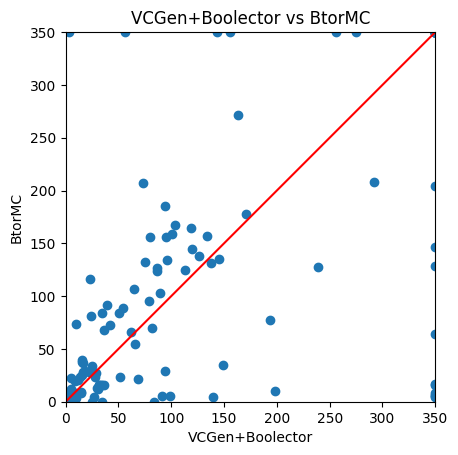

In [ ]:
scatter_values('btormc_time', vcGenBtor, b20s, "VCGen+Boolector", "BtorMC")

In [ ]:
vcGenBtor.query('btormc_time > 180 and btormc_time < 200')

,base,vcGen_total,btor_time,btormc_time
8,picorv32-check-p22.btor,189.16,9.071,198.231
4,dspfilters_fastfir_second-p09.btor,14.80,178.743,193.543


In [ ]:
df = b20s.query('btormc_time > 300')

In [ ]:
z3 = sea_18D[['base', 'seahorn_total']]
z3 = z3.rename(columns = {'seahorn_total': 'btormc_time'})

for sea in sea_results[1:]:
  sea = sea.rename(columns = {'seahorn_total': 'btormc_time'})
  z3 = pd.concat([z3, sea[['base', 'btormc_time']]])
z3.loc[z3['btormc_time'] >= 1000, 'btormc_time'] = 350
# z3

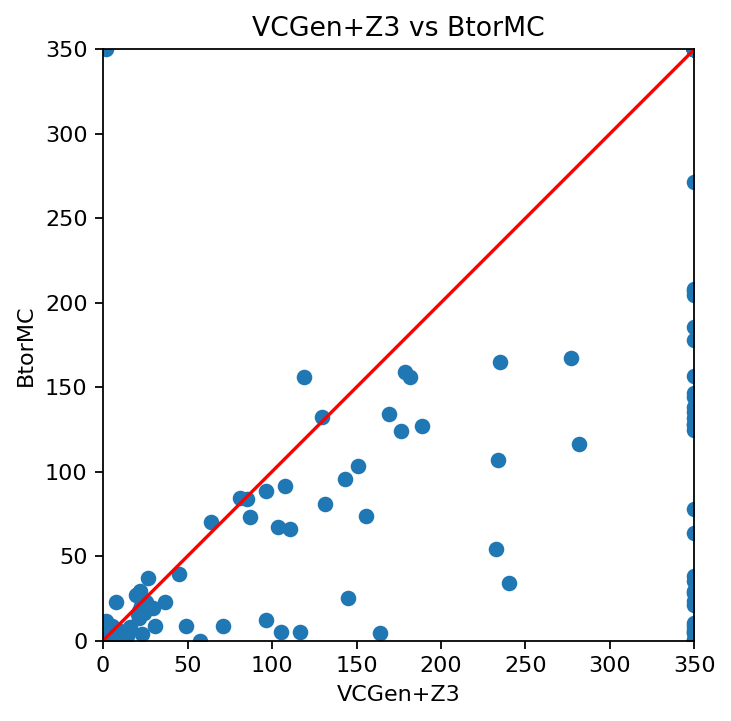

In [ ]:
scatter_values('btormc_time', z3, b20s, "VCGen+Z3", "BtorMC")

In [ ]:
df = b20s.query('btormc_time > 300')
df2 = z3.query('btormc_time < 20')
df3 = pd.merge(df, df2, how='inner', on='base')
df3

,base,btormc_time_x,status,btormc_time_y
0,elevator.4.prop1-func-interl.btor2,350.0,unknown,1.93


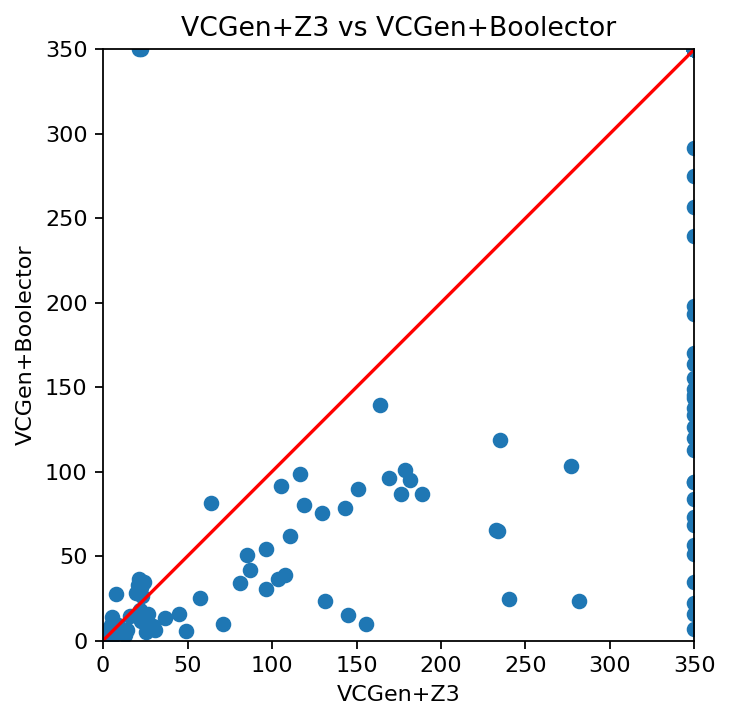

In [ ]:
scatter_values('btormc_time', z3, vcGenBtor, "VCGen+Z3", "VCGen+Boolector")